In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

loc = 'SlumClassifier/assets/model.keras'
PATH = 'SlumClassifier'
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [6]:
model = tf.keras.models.load_model(loc, compile=False)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data_gen = test_image_generator.flow_from_directory(
                    PATH,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=5,
                    classes=['test'],
                    shuffle=False)

probabilities = model.predict(test_data_gen).flatten()
probabilities

Found 10 images belonging to 1 classes.
1/2 [==============>...............] - ETA: 0s

2024-03-01 11:15:32.349378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 0s 80ms/step


array([0.66294545, 0.6229022 , 0.6063831 , 0.60610074, 0.68465054,
       0.78921735, 0.9218813 , 0.9502367 , 0.9621213 , 0.90796417],
      dtype=float32)

In [14]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% Slum")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% Not Slum")
    plt.show()

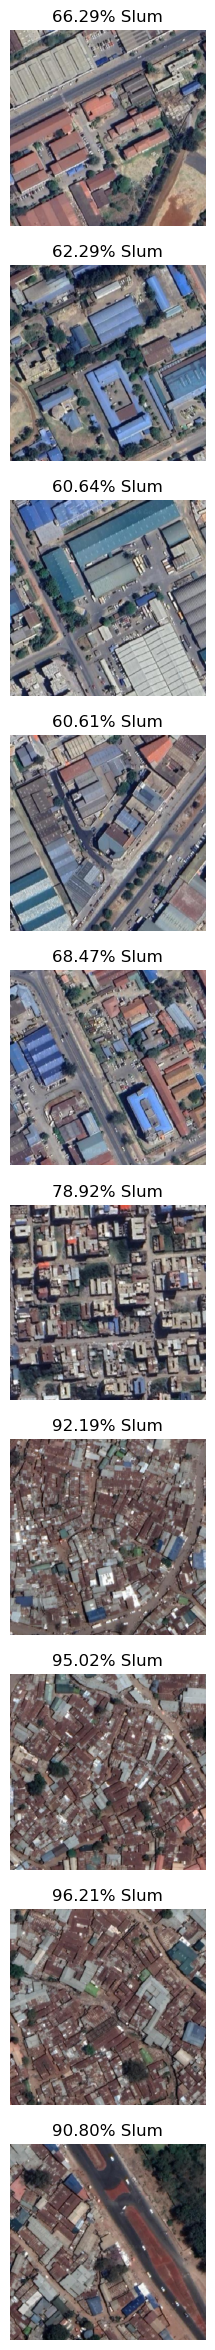

In [15]:
demo_images = [test_data_gen[0][0][i] for i in range(5)] + [test_data_gen[1][0][i] for i in range(5)]

plotImages(demo_images, probabilities)

In [16]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

In [17]:
from tf_keras_vis.utils.scores import BinaryScore
score = BinaryScore(1) # or BinaryScore(True) 

from matplotlib import cm  #color map
from tf_keras_vis.gradcam import Gradcam #Gradcam

In [18]:
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

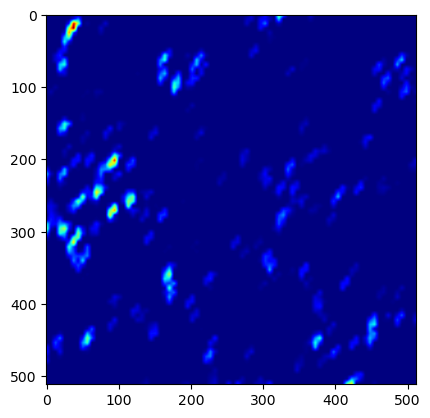

In [19]:
def create_heat(score, im_arr):
       cam = [gradcam(score, im_arr[0], penultimate_layer=-1), gradcam(score, im_arr[1], penultimate_layer=-1), 
              gradcam(score, im_arr[2], penultimate_layer=-1), gradcam(score, im_arr[3], penultimate_layer=-1),
              gradcam(score, im_arr[4], penultimate_layer=-1), gradcam(score, im_arr[5], penultimate_layer=-1),
              gradcam(score, im_arr[6], penultimate_layer=-1), gradcam(score, im_arr[7], penultimate_layer=-1)] 
       return cam
#creates gradcam heatmap using specified layer
cam = create_heat(score, demo_images)
plt.imshow(np.uint8(cm.jet(cam[1][0])[..., :3] * 255))

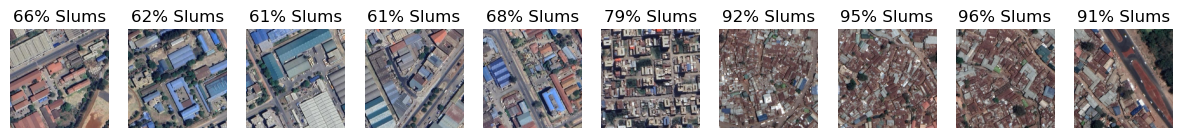

In [26]:
fig, axes = plt.subplots(1, 10, figsize=(15, 15))

for img, probability, ax in zip(demo_images, probabilities, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("%.0f" % ((probability)*100) + "% Slums")
plt.show()

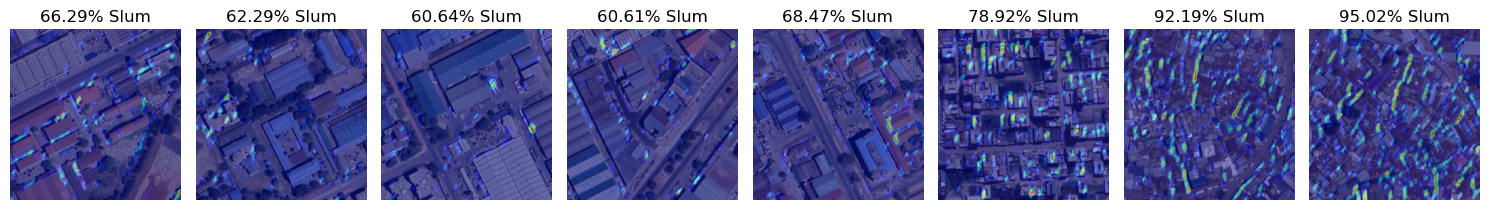

In [24]:
fig, axes = plt.subplots(1, 8, figsize=(15, 15))
count = 0
for img, ax in zip(demo_images, axes):
    heatmap = np.uint8(cm.jet(cam[count][0])[..., :3] * 255)
    ax.imshow(img)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    ax.set_title("%.2f" % ((probabilities[count])*100) + "% Slum")
    ax.axis('off')
    count+=1
plt.tight_layout()
plt.show()